## Import libs

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset
import seaborn as sns


from models.unfair_lr.models import UnfairLogisticRegression
from models.unfair_lr.learning import train_loop
from util.evaluation import *
from util.load_data import load_data

## Preliminaries

In [2]:
batch_size = 64
epochs = 100
lr = 0.001

In [3]:
cv_seeds = [13, 29, 42, 55, 73]

## Load data

In [4]:
data_name = 'titanic'

In [5]:
x, y, a = load_data(data_name)
raw_data = (x, y, a)

In [6]:
xdim = x.shape[1]
ydim = y.shape[1]
adim = a.shape[1]
zdim = 8

## Result file

In [7]:
header = "model_name", "cv_seed", "clas_acc", "dp", "deqodds", "deqopp", "trade_dp", "trade_deqodds", "trade_deqopp", "TN_a0", "FP_a0", "FN_a0", "TP_a0", "TN_a1", "FP_a1", "FN_a1", "TP_a1"
results = []

## Testing

In [8]:
for cv_seed in cv_seeds:
    x_train, x_test, y_train, y_test, a_train, a_test = train_test_split(
        x, y, a, test_size=0.3, random_state=cv_seed)

    train_data = Dataset.from_tensor_slices((x_train, y_train, a_train))
    train_data = train_data.batch(batch_size, drop_remainder=True)

    test_data = Dataset.from_tensor_slices((x_test, y_test, a_test))
    test_data = test_data.batch(batch_size, drop_remainder=True)

    # train below

    model = UnfairLogisticRegression(xdim, ydim, batch_size)
    ret = train_loop(model, train_data, epochs)
    Y, A, Y_hat = evaluation(model, test_data)
    
    clas_acc, dp, deqodds, deqopp, confusion_matrix, metrics_a0, metrics_a1  = compute_metrics(Y, A, Y_hat, adim=adim)
    
    fair_metrics = (dp, deqodds, deqopp)
    
    tradeoff = []
    
    for fair_metric in fair_metrics:
        tradeoff.append(compute_tradeoff(clas_acc, fair_metric))
    
    result = ['UnfairLR-decay', cv_seed, clas_acc, dp, deqodds, deqopp, tradeoff[0], tradeoff[1], tradeoff[2]] + metrics_a0 + metrics_a1

    results.append(result)

> Epoch | Class Loss | Class Acc
> 1 | 0.9008842706680298 | 0.3645833333333333
> 2 | 0.8942244052886963 | 0.3576388888888889
> 3 | 0.8893353939056396 | 0.3576388888888889
> 4 | 0.8857583999633789 | 0.3576388888888889
> 5 | 0.8834515810012817 | 0.3576388888888889
> 6 | 0.880972146987915 | 0.3611111111111111
> 7 | 0.8789172172546387 | 0.359375
> 8 | 0.8771583437919617 | 0.359375
> 9 | 0.8759320974349976 | 0.3576388888888889
> 10 | 0.8744905591011047 | 0.359375
> 11 | 0.8732051849365234 | 0.359375
> 12 | 0.8722895979881287 | 0.359375
> 13 | 0.8711854815483093 | 0.359375
> 14 | 0.8701767921447754 | 0.359375
> 15 | 0.8694486618041992 | 0.359375
> 16 | 0.8685561418533325 | 0.359375
> 17 | 0.8677276372909546 | 0.359375
> 18 | 0.8671241998672485 | 0.359375
> 19 | 0.8663761615753174 | 0.359375
> 20 | 0.8658287525177002 | 0.359375
> 21 | 0.8651478290557861 | 0.359375
> 22 | 0.8645058870315552 | 0.359375
> 23 | 0.864033579826355 | 0.359375
> 24 | 0.8634417057037354 | 0.359375
> 25 | 0.86300504207

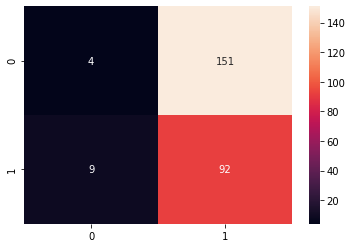

In [9]:
sns.heatmap(confusion_matrix, annot=True, fmt='g')

In [10]:
for cv_seed in cv_seeds:
    x_train, x_test, y_train, y_test, a_train, a_test = train_test_split(
        x, y, a, test_size=0.3, random_state=cv_seed)

    train_data = Dataset.from_tensor_slices((x_train, y_train, a_train))
    train_data = train_data.batch(batch_size, drop_remainder=True)

    test_data = Dataset.from_tensor_slices((x_test, y_test, a_test))
    test_data = test_data.batch(batch_size, drop_remainder=True)

    # train below

    opt = Adam(learning_rate=lr)

    model = UnfairLogisticRegression(xdim, ydim, batch_size)
    ret = train_loop(model, train_data, epochs, opt)
    Y, A, Y_hat = evaluation(model, test_data)
    
    clas_acc, dp, deqodds, deqopp, confusion_matrix, metrics_a0, metrics_a1  = compute_metrics(Y, A, Y_hat, adim=adim)
    
    fair_metrics = (dp, deqodds, deqopp)
    
    tradeoff = []
    
    for fair_metric in fair_metrics:
        tradeoff.append(compute_tradeoff(clas_acc, fair_metric))
    
    result = ['UnfairLR', cv_seed, clas_acc, dp, deqodds, deqopp, tradeoff[0], tradeoff[1], tradeoff[2]] + metrics_a0 + metrics_a1

    results.append(result)

    del(opt)

> Epoch | Class Loss | Class Acc
> 1 | 0.9008842706680298 | 0.3645833333333333
> 2 | 0.8850905895233154 | 0.34375
> 3 | 0.87254798412323 | 0.3420138888888889
> 4 | 0.861292839050293 | 0.3454861111111111
> 5 | 0.849582314491272 | 0.3576388888888889
> 6 | 0.8370593786239624 | 0.3645833333333333
> 7 | 0.8250463008880615 | 0.3663194444444444
> 8 | 0.8138713836669922 | 0.3663194444444444
> 9 | 0.8032193183898926 | 0.3680555555555556
> 10 | 0.79282146692276 | 0.375
> 11 | 0.7827056646347046 | 0.3767361111111111
> 12 | 0.7729858160018921 | 0.3819444444444444
> 13 | 0.7636600732803345 | 0.3923611111111111
> 14 | 0.754673957824707 | 0.4097222222222222
> 15 | 0.7460082173347473 | 0.4114583333333333
> 16 | 0.7376683950424194 | 0.4131944444444444
> 17 | 0.7296465635299683 | 0.4236111111111111
> 18 | 0.7219256162643433 | 0.4253472222222222
> 19 | 0.7144930362701416 | 0.4340277777777778
> 20 | 0.7073391079902649 | 0.4340277777777778
> 21 | 0.7004526853561401 | 0.4513888888888889
> 22 | 0.69382172822

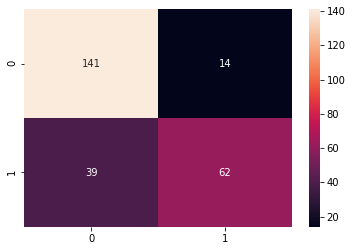

In [11]:
sns.heatmap(confusion_matrix, annot=True, fmt='g')

## Saving into DF then CSV

In [12]:
result_df = pd.DataFrame(results, columns=header)
result_df

,model_name,cv_seed,clas_acc,dp,deqodds,deqopp,trade_dp,trade_deqodds,trade_deqopp,TN_a0,FP_a0,FN_a0,TP_a0,TN_a1,FP_a1,FN_a1,TP_a1
0,UnfairLR-decay,13,0.417969,0.957176,0.958974,0.933333,0.581858,0.582190,0.577375,0.0,16.0,5.0,70.0,2.0,128.0,0.0,35.0
1,UnfairLR-decay,29,0.312500,0.878933,0.967213,0.956455,0.461069,0.472378,0.471084,2.0,23.0,16.0,45.0,8.0,130.0,7.0,25.0
2,UnfairLR-decay,42,0.367188,0.996268,0.987042,0.974085,0.536603,0.535256,0.533332,0.0,28.0,1.0,70.0,0.0,132.0,1.0,24.0
3,UnfairLR-decay,55,0.382812,0.999723,0.984993,0.984375,0.553630,0.551347,0.551250,0.0,20.0,1.0,63.0,2.0,137.0,0.0,33.0
4,UnfairLR-decay,73,0.375000,0.956169,0.984283,0.987331,0.538720,0.543089,0.543552,1.0,23.0,6.0,58.0,3.0,128.0,3.0,34.0
5,UnfairLR,13,0.714844,0.561172,0.703649,0.540952,0.628755,0.709202,0.615859,13.0,3.0,32.0,43.0,123.0,7.0,31.0,4.0
6,UnfairLR,29,0.800781,0.495486,0.683811,0.589652,0.612182,0.737688,0.679187,18.0,7.0,15.0,46.0,130.0,8.0,21.0,11.0
7,UnfairLR,42,0.753906,0.522422,0.650464,0.618028,0.617172,0.698376,0.679238,17.0,11.0,24.0,47.0,122.0,10.0,18.0,7.0
8,UnfairLR,55,0.753906,0.575305,0.735783,0.556818,0.652606,0.744734,0.640545,17.0,3.0,24.0,40.0,130.0,9.0,27.0,6.0
9,UnfairLR,73,0.792969,0.482684,0.677072,0.543074,0.600090,0.730451,0.644651,18.0,6.0,14.0,50.0,123.0,8.0,25.0,12.0


In [13]:
result_df.to_csv(f'{data_name}-result/unfair_lr-{epochs}.csv')